In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

In [2]:
combined_df = pd.read_csv('combined_df.csv', index_col=0)

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
def sample(df, target_variable, sample_size=100):
    
    '''
    Pulls a user defined sample of the given data set, and keeps the class representation of the original data set.
    '''
    
    df.drop(df[df[target_variable] == 'OT'].index, inplace=True)
    appended_data = []
    perc_dict = {k:v/len(df) for k, v in list(df[target_variable].value_counts().items())[0:3]}
    
    for k in perc_dict.keys():
        n = round(sample_size * perc_dict[k])
        data = df[df[target_variable] == k].sample(n=n, random_state=11)
        appended_data.append(data)

    sample_df = pd.concat(appended_data)
    
    return sample_df

In [6]:
def split_data(df, target_variable, sample_df, sample_size=100, **kwargs):
    
    '''
    Function that does the train_test_split. Can sample the data set before hand, or choose a specific pitcher
    by specifying first_name and last_name
    '''

    if sample_df and kwargs:
        raise ValueError(
            'Can not choose a pitcher and sample at the same time. Must choose one or the other')

    if sample_df:
        df = sample(df, target_variable, sample_size)

    if kwargs:
        kwarg_list = list(kwargs.items())
        df = df[(df[kwarg_list[0][0]] == kwarg_list[0][1]) &
                (df[kwarg_list[1][0]] == kwarg_list[1][1])]

    X = df.drop([target_variable, 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                 'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                 'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
    y = df[target_variable]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=47, stratify=y)
        
    return X_tr, X_te, y_tr, y_te

In [5]:
def find_best_params(df, target_variable, *args, **kwargs):
    
    '''
    Finds the best parameters of each individual model via cross validation for future modeling use.
    '''
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, *args, **kwargs)
    
    model_list = [RandomForestClassifier(), GradientBoostingClassifier(), 
                  AdaBoostClassifier(), KNeighborsClassifier()]
        
    for model in model_list:
        if model == model_list[0]:
            steps = [('rf', RandomForestClassifier(random_state=11))]
            param_grid = {'rf__n_estimators': np.arange(500, 5000, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_rf = cv.best_params_['rf__n_estimators']
            
        elif model == model_list[1]:
            steps = [('gboost', GradientBoostingClassifier(random_state=11))]
            param_grid = {'gboost__n_estimators': np.arange(500, 1500, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_gboost = cv.best_params_['gboost__n_estimators']
                        
        elif model == model_list[2]:
            steps = [('aboost', AdaBoostClassifier(random_state=11))]
            param_grid = {'aboost__n_estimators': np.arange(500, 5000, 500)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_aboost = cv.best_params_['aboost__n_estimators']
                        
        elif model == model_list[3]:
            steps = [('knn', KNeighborsClassifier())]
            param_grid = {'knn__n_neighbors': np.arange(9, 23, 2)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_knn = cv.best_params_['knn__n_neighbors']
        
    print(f'Best Random Forest estimators: {best_rf}')
    print(f'Best Gradient Boosting estimators: {best_gboost}')
    print(f'Best Ada Boosting estimators: {best_aboost}')
    print(f'Best K Neighbors: {best_knn}')
        
    return best_rf, best_gboost, best_aboost, best_knn

In [6]:
def get_classification_report(df, target_variable, *args, **kwargs):
    
    '''
    All chosen models get input from the find_best_params function, and is used to fit and predict the data
    '''
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, *args, **kwargs)
    
    best_rf, best_gboost, best_aboost, best_knn = find_best_params(df, target_variable, *args, **kwargs)
    
    rf = RandomForestClassifier(n_estimators=best_rf, random_state=11)
    gboost = GradientBoostingClassifier(n_estimators=best_gboost, random_state=11)
    aboost = AdaBoostClassifier(n_estimators=best_aboost, random_state=11)
    knn = KNeighborsClassifier(n_neighbors=best_knn)
    
    rf_fit = rf.fit(X_train, y_train)
    gboost_fit = gboost.fit(X_train, y_train)
    aboost_fit = aboost.fit(X_train, y_train)
    knn_fit = knn.fit(X_train, y_train)
    
    rf_predict = rf.predict(X_test)
    gboost_predict = gboost.predict(X_test)
    aboost_predict = aboost.predict(X_test)
    knn_predict = knn.predict(X_test)

    target_names = rf.classes_
    print('Random Forest Classification Report:')
    print(classification_report(y_test, rf_predict, target_names=target_names))
    print('Gradient Boosting Classification Report:')
    print(classification_report(y_test, gboost_predict, target_names=target_names))
    print('Ada Boosting Classification Report:')
    print(classification_report(y_test, aboost_predict, target_names=target_names))
    print('K Neighbors Classification Report:')
    print(classification_report(y_test, knn_predict, target_names=target_names))
    

In [35]:
%%time
get_classification_report(combined_df, 'pitch_type', sample_size=10000, sample_df=True)

Best Random Forest estimators: 2500
Best Gradient Boosting estimators: 500
Best Ada Boosting estimators: 1000
Best K Neighbors: 9
Random Forest Classification Report:
              precision    recall  f1-score   support

          BB       0.39      0.29      0.33       792
          FB       0.59      0.74      0.66      1402
          OS       0.14      0.06      0.09       306

    accuracy                           0.52      2500
   macro avg       0.37      0.37      0.36      2500
weighted avg       0.47      0.52      0.48      2500

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.42      0.19      0.26       792
          FB       0.58      0.87      0.69      1402
          OS       0.27      0.01      0.02       306

    accuracy                           0.55      2500
   macro avg       0.42      0.36      0.32      2500
weighted avg       0.49      0.55      0.47      2500

Ada Boosting Classification Re

In [10]:
%%time
get_classification_report(combined_df, 'pitch_type', sample_size=100000, sample_df=True)

Best Random Forest estimators: 4000
Best Gradient Boosting estimators: 500
Best Ada Boosting estimators: 2500
Best K Neighbors: 21
Random Forest Classification Report:
              precision    recall  f1-score   support

          BB       0.37      0.30      0.33      7920
          FB       0.58      0.71      0.64     14018
          OS       0.19      0.09      0.12      3062

    accuracy                           0.50     25000
   macro avg       0.38      0.37      0.36     25000
weighted avg       0.47      0.50      0.48     25000

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.44      0.10      0.16      7920
          FB       0.57      0.94      0.71     14018
          OS       0.26      0.00      0.00      3062

    accuracy                           0.56     25000
   macro avg       0.42      0.35      0.29     25000
weighted avg       0.49      0.56      0.45     25000

Ada Boosting Classification R

In [ ]:
def gradient_boost(df, target_variable, *args, **kwargs):
    
    '''
    Gradient boosting won as the best model. This function specifically focuses on gradient boosting and gives
    feature importances in a graphical form.
    '''

    X_train, X_test, y_train, y_test = split_data(df, target_variable, *args, **kwargs)

    steps = [('gboost', GradientBoostingClassifier(random_state=11))]
    param_grid = {'gboost__n_estimators': np.arange(100, 1100, 100)}

    pipeline = Pipeline(steps)
    cv = GridSearchCV(pipeline, param_grid, cv=3)
    cv.fit(X_train, y_train)

    best_gboost = cv.best_params_['gboost__n_estimators']
    print(best_gboost)

    gboost = GradientBoostingClassifier(
        n_estimators=best_gboost, random_state=11)
    gboost_fit = gboost.fit(X_train, y_train)
    gboost_predict = gboost.predict(X_test)

    feature_importances = pd.DataFrame(pd.Series(gboost.feature_importances_), columns=['Importance'])
    feature_importances.index = X_train.columns
    feature_importances = feature_importances.sort_values('Importance')

    plt.figure(figsize=(18,10))
    plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
    plt.title("Gradient Boosting Feature Importances (%)")
    plt.xlabel('Percentage Importance')
    plt.show()

    target_names = gboost.classes_
    print('Gradient Boosting Classification Report:')
    print(classification_report(y_test, gboost_predict, target_names=target_names))


200


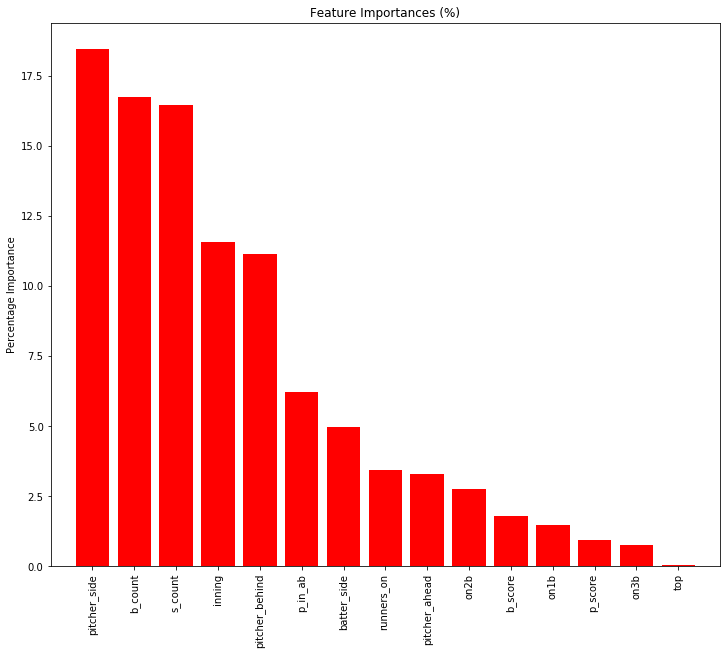

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.47      0.08      0.14     79195
          FB       0.57      0.96      0.71    140182
          OS       0.71      0.00      0.00     30623

    accuracy                           0.56    250000
   macro avg       0.58      0.35      0.28    250000
weighted avg       0.55      0.56      0.44    250000



In [9]:
gradient_boost(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)

500


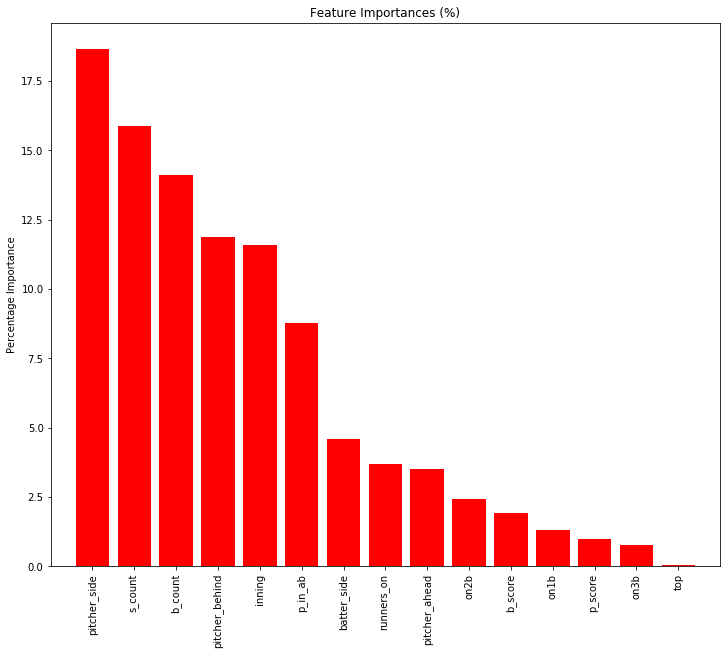

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.47      0.09      0.15    225509
          FB       0.57      0.95      0.71    399170
          OS       0.71      0.00      0.00     87199

    accuracy                           0.56    711878
   macro avg       0.58      0.35      0.29    711878
weighted avg       0.55      0.56      0.45    711878



In [10]:
gradient_boost(combined_df, 'pitch_type')

In [29]:
def gradient_boost_sampling(df, target_variable, *args, **kwargs):
    
    '''
    Function that takes random numbers from 48798-348798 to test different levels of class representation with
    the gradient boosting model. Performs 5 test runs
    '''
    
    df.drop(df[df[target_variable] == 'OT'].index, inplace=True)
    sample_list = list(np.arange(48798, 368798, 20000))
    FB_percs = []
    BB_percs = []
    OS_percs = []
    test_scores = []
    
    n=1
    while n <= 5:
        
        appended_data = []
        
        for i in df[target_variable].unique():
            data = df[df[target_variable] == i].sample(n=np.random.choice(sample_list, replace=False), replace=True, random_state=11)
            appended_data.append(data)
            
        sample_df = pd.concat(appended_data)
        FB_percs.append(round(sample_df[sample_df[target_variable] == 'FB'][target_variable].count()/len(sample_df) * 100, 2))
        BB_percs.append(round(sample_df[sample_df[target_variable] == 'BB'][target_variable].count()/len(sample_df) * 100, 2))
        OS_percs.append(round(sample_df[sample_df[target_variable] == 'OS'][target_variable].count()/len(sample_df) * 100, 2))
    
        X = sample_df.drop([target_variable, 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                            'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                            'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
        y = sample_df[target_variable]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, stratify=y)

        steps = [('gboost', GradientBoostingClassifier(random_state=11))]
        param_grid = {'gboost__n_estimators': np.arange(500, 1100, 100)}

        pipeline = Pipeline(steps)
        cv = GridSearchCV(pipeline, param_grid, cv=3)
        cv.fit(X_train, y_train)

        best_gboost = cv.best_params_['gboost__n_estimators']

        gboost = GradientBoostingClassifier(n_estimators=best_gboost, random_state=11)
        gboost_fit = gboost.fit(X_train, y_train)
        gboost_predict = gboost.predict(X_test)

        feature_importances = pd.DataFrame(pd.Series(gboost.feature_importances_), columns=['Importance'])
        feature_importances.index = X_train.columns
        feature_importances = feature_importances.sort_values('Importance')

        plt.figure(figsize=(18,10))
        plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
        plt.title("Gradient Boosting Feature Importances (%)")
        plt.xlabel('Percentage Importance')
        plt.show()

        target_names = gboost.classes_
        print('Gradient Boosting Classification Report:')
        print(classification_report(y_test, gboost_predict, target_names=target_names))
        
        test_scores.append(round(gboost.score(X_test, y_test) * 100, 2))
        
        n += 1
        
    perc_dict = {'FB_percs': FB_percs, 'BB_percs': BB_percs, 'OS_percs': OS_percs, 'test_scores': test_scores}
    
    info_df = pd.DataFrame.from_dict(perc_dict)
    
    return info_df

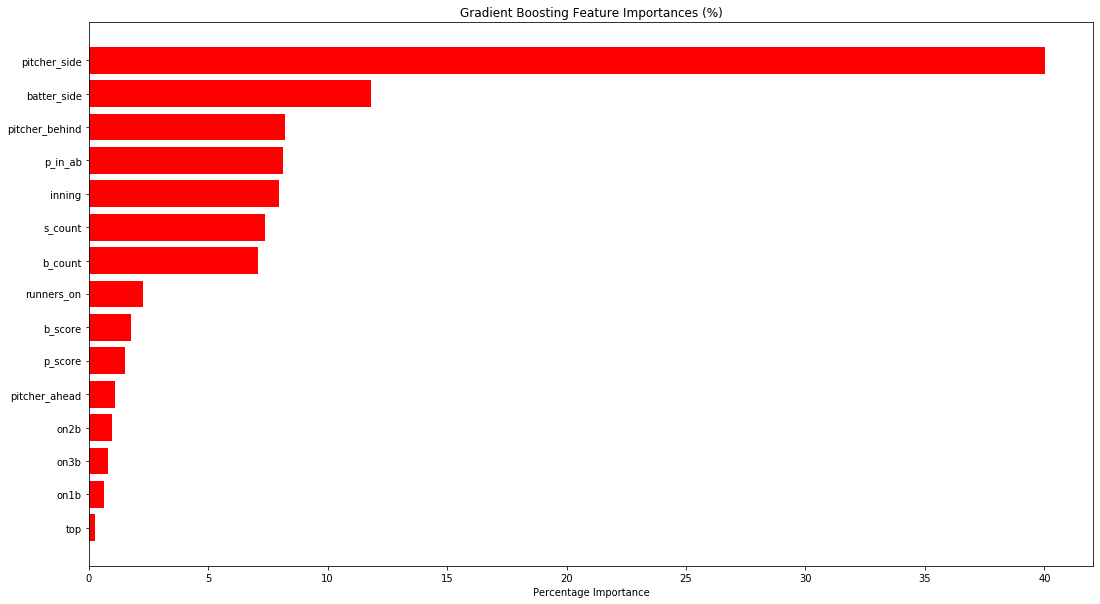

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.58      0.90      0.70     87200
          FB       0.52      0.09      0.15     32199
          OS       0.45      0.21      0.29     42200

    accuracy                           0.56    161599
   macro avg       0.52      0.40      0.38    161599
weighted avg       0.53      0.56      0.48    161599



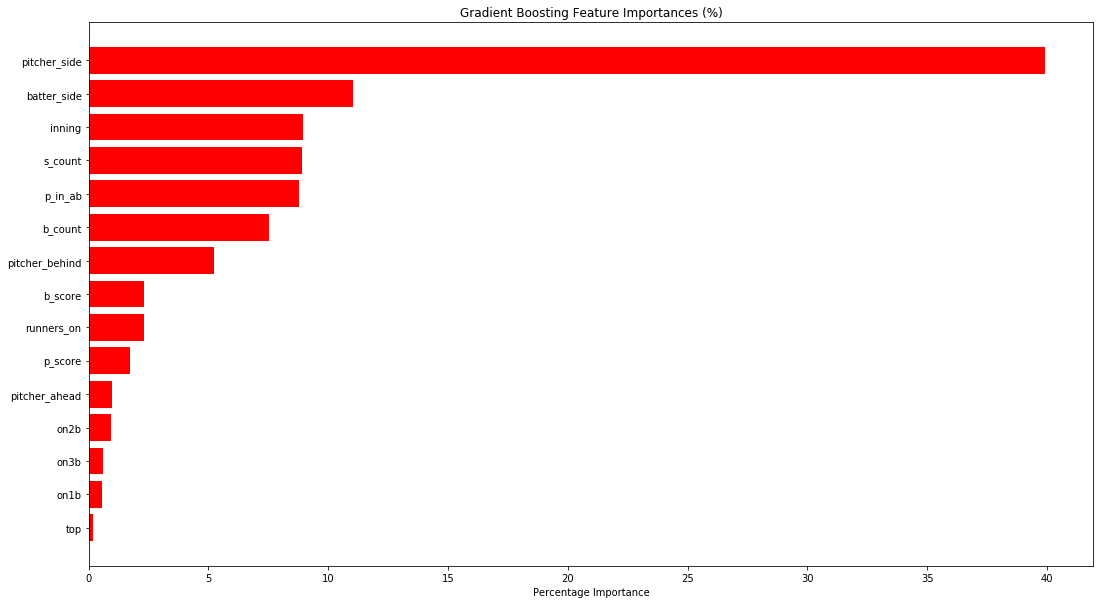

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.47      0.48      0.47     42200
          FB       0.52      0.15      0.24     32199
          OS       0.52      0.74      0.61     52200

    accuracy                           0.50    126599
   macro avg       0.50      0.46      0.44    126599
weighted avg       0.50      0.50      0.47    126599



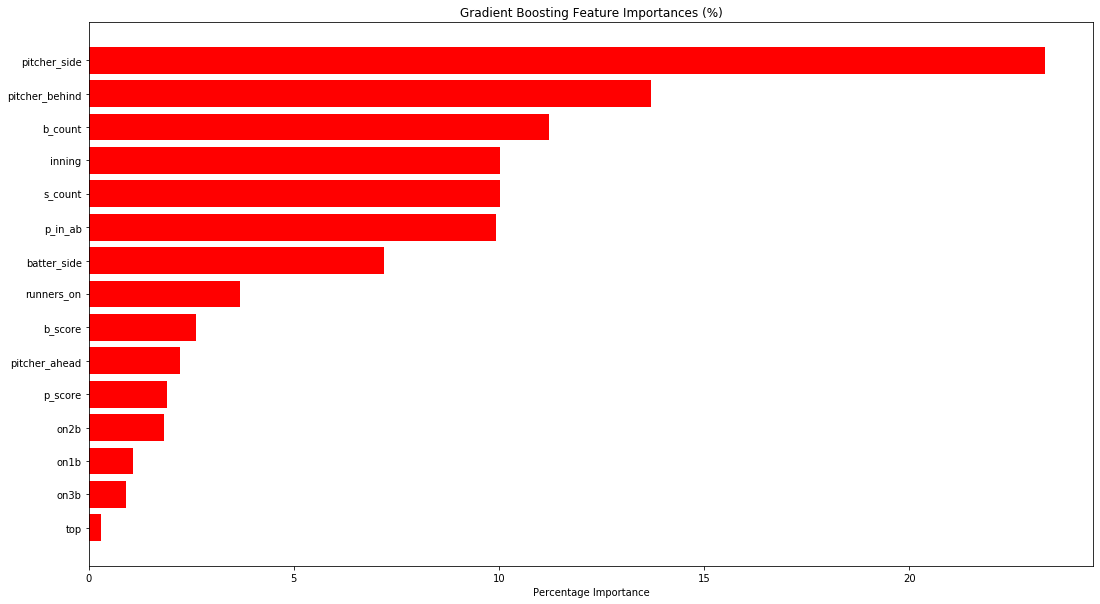

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.63      0.97      0.77     87200
          FB       0.57      0.12      0.20     37200
          OS       0.28      0.00      0.00     17199

    accuracy                           0.63    141599
   macro avg       0.49      0.36      0.32    141599
weighted avg       0.57      0.63      0.52    141599



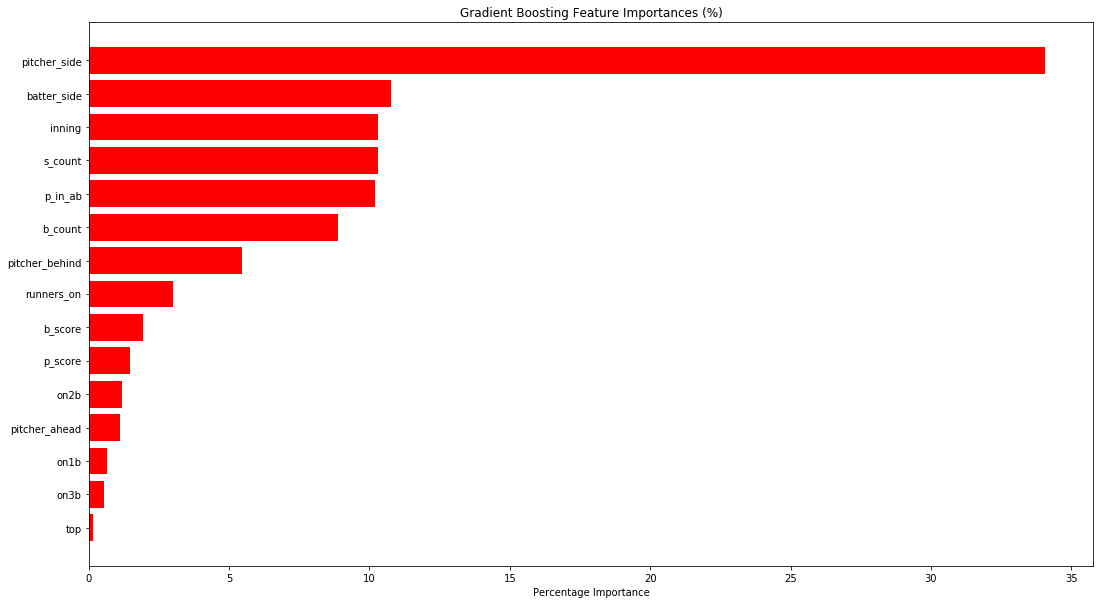

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.42      0.33      0.37     67199
          FB       0.50      0.38      0.43     82200
          OS       0.49      0.68      0.57     87200

    accuracy                           0.48    236599
   macro avg       0.47      0.46      0.46    236599
weighted avg       0.47      0.48      0.46    236599



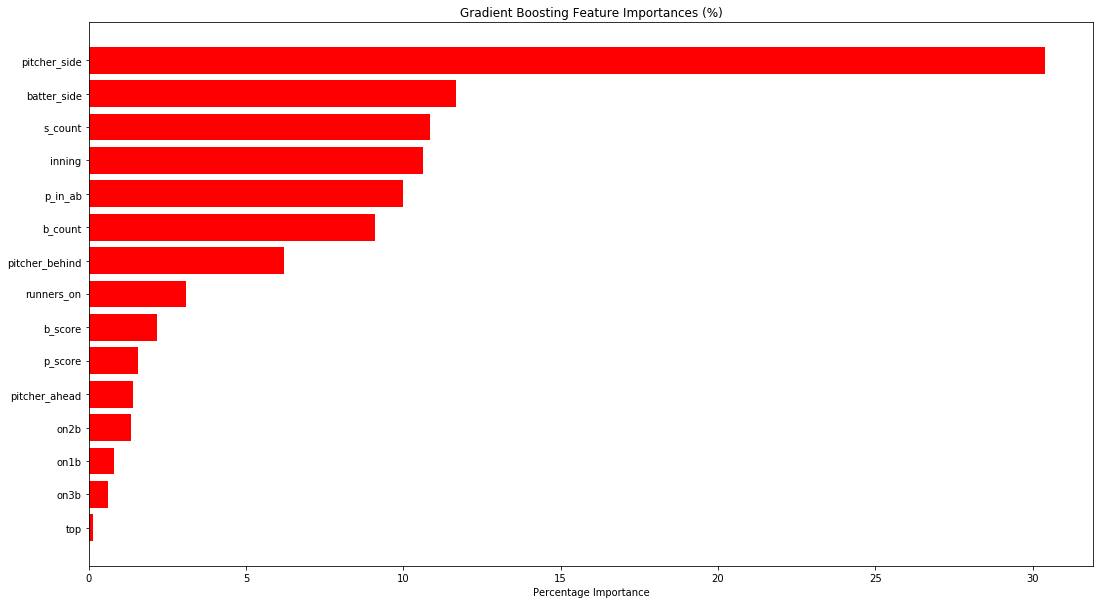

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          BB       0.43      0.38      0.41     62199
          FB       0.50      0.46      0.48     77200
          OS       0.44      0.54      0.49     62200

    accuracy                           0.46    201599
   macro avg       0.46      0.46      0.46    201599
weighted avg       0.46      0.46      0.46    201599



,FB_percs,BB_percs,OS_percs,test_scores
0,19.93,53.96,26.11,0.56
1,25.43,33.33,41.23,0.50
2,26.27,61.58,12.15,0.63
3,34.74,28.40,36.86,0.48
4,38.29,30.85,30.85,0.46


In [30]:
gradient_boost_sampling(combined_df, 'pitch_type')

## Simple Neural Network

In [75]:
X_train, X_test, y_train, y_test = split_data(combined_df, 'pitch_type', sample_df=True, sample_size=1000000)

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 1394906 to 2438656
Data columns (total 15 columns):
b_count           750000 non-null int64
s_count           750000 non-null int64
b_score           750000 non-null int64
batter_side       750000 non-null float64
inning            750000 non-null int64
on1b              750000 non-null float64
on2b              750000 non-null float64
on3b              750000 non-null float64
p_score           750000 non-null int64
pitcher_side      750000 non-null float64
top               750000 non-null float64
pitcher_ahead     750000 non-null float64
pitcher_behind    750000 non-null float64
p_in_ab           750000 non-null int64
runners_on        750000 non-null int64
dtypes: float64(8), int64(7)
memory usage: 91.6 MB


### Without resampling

In [77]:
mlp = MLPClassifier(hidden_layer_sizes=(15,15,15,15,15,15,15,15), max_iter=10000, random_state=11)

In [78]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          BB       0.47      0.10      0.16     79195
          FB       0.57      0.95      0.71    140182
          OS       0.00      0.00      0.00     30623

    accuracy                           0.56    250000
   macro avg       0.35      0.35      0.29    250000
weighted avg       0.47      0.56      0.45    250000



### With resampling

In [79]:
y_train.value_counts()

FB    420546
BB    237585
OS     91869
Name: pitch_type, dtype: int64

In [80]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.5), 
                              'OS': int(y_train.value_counts().values[0] / 2)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

y_tr_res.value_counts()

FB    420546
BB    280364
OS    210273
Name: pitch_type, dtype: int64

In [81]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(classification_report(y_test, res_pred))

              precision    recall  f1-score   support

          BB       0.44      0.23      0.31     79195
          FB       0.59      0.78      0.67    140182
          OS       0.24      0.19      0.21     30623

    accuracy                           0.53    250000
   macro avg       0.42      0.40      0.40    250000
weighted avg       0.50      0.53      0.50    250000



In [82]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0] / 1.25), 
                              'OS': int(y_train.value_counts().values[0] / 1.5)}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

FB    420546
BB    336436
OS    280364
Name: pitch_type, dtype: int64


In [83]:
mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(classification_report(y_test, res_pred))

              precision    recall  f1-score   support

          BB       0.42      0.39      0.40     79195
          FB       0.63      0.56      0.59    140182
          OS       0.21      0.36      0.27     30623

    accuracy                           0.48    250000
   macro avg       0.42      0.44      0.42    250000
weighted avg       0.51      0.48      0.49    250000



In [84]:
sm = SMOTE(sampling_strategy={'FB':     y_train.value_counts().values[0], 
                              'BB': int(y_train.value_counts().values[0]), 
                              'OS': int(y_train.value_counts().values[0])}, random_state=42)
X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)

print(y_tr_res.value_counts())

mlp.fit(X_tr_res, y_tr_res)
res_pred = mlp.predict(X_test)
print(classification_report(y_test, res_pred))

BB    420546
OS    420546
FB    420546
Name: pitch_type, dtype: int64
              precision    recall  f1-score   support

          BB       0.41      0.46      0.43     79195
          FB       0.67      0.41      0.51    140182
          OS       0.20      0.48      0.28     30623

    accuracy                           0.44    250000
   macro avg       0.42      0.45      0.41    250000
weighted avg       0.53      0.44      0.46    250000

